In [1]:
import numpy as np
import pandas as pd

# Train Dataset

In [2]:
aspect_dev_df = pd.read_csv("aspect-dev.csv")

In [3]:
aspect_train_df = pd.read_csv("aspect-train.csv")
aspect_train_df.head()

,Unnamed: 0,id,text,aspectCategory,polarity,tokens
0,0,3121,But the staff was so horrible to us.,service,negative,"['But', 'the', 'staff', 'was', 'so', 'horrible..."
1,1,2777,"To be completely fair, the only redeeming fact...",food,positive,"['To', 'be', 'completely', 'fair,', 'the', 'on..."
2,2,2777,"To be completely fair, the only redeeming fact...",anecdotes/miscellaneous,negative,"['To', 'be', 'completely', 'fair,', 'the', 'on..."
3,3,1634,"The food is uniformly exceptional, with a very...",food,positive,"['The', 'food', 'is', 'uniformly', 'exceptiona..."
4,4,2534,Where Gabriela personaly greets you and recomm...,service,positive,"['Where', 'Gabriela', 'personaly', 'greets', '..."


In [4]:
food_train = aspect_train_df.loc[aspect_train_df['aspectCategory']=="food", 'text']
price_train = aspect_train_df.loc[aspect_train_df['aspectCategory']=="price", 'text']
service_train = aspect_train_df.loc[aspect_train_df['aspectCategory']=="service", 'text']
place_train = aspect_train_df.loc[aspect_train_df['aspectCategory']=="ambience", "text"]

food_dev = aspect_dev_df.loc[aspect_dev_df['aspectCategory']=="food", 'text']
price_dev = aspect_dev_df.loc[aspect_dev_df['aspectCategory']=="price", 'text']
service_dev = aspect_dev_df.loc[aspect_dev_df['aspectCategory']=="service", 'text']
place_dev = aspect_dev_df.loc[aspect_dev_df['aspectCategory']=="ambience", "text"]

In [5]:
train_dfs = [
    pd.DataFrame({'text': food_train, 'category': 'food'}),
    pd.DataFrame({'text': price_train, 'category': 'price'}),
    pd.DataFrame({'text': service_train, 'category': 'service'}),
    pd.DataFrame({'text': place_train, 'category': 'place'})
]

train_df = pd.concat(train_dfs, ignore_index=True)

dev_dfs = [
    pd.DataFrame({'text': food_dev, 'category': 'food'}),
    pd.DataFrame({'text': price_dev, 'category': 'price'}),
    pd.DataFrame({'text': service_dev, 'category': 'service'}),
    pd.DataFrame({'text': place_dev, 'category': 'place'})
]

dev_df = pd.concat(dev_dfs, ignore_index=True)

final_df = pd.concat([train_df, dev_df], ignore_index=True)

In [6]:
final_df['category'].value_counts()

category
food       1051
service     506
place       368
price       275
Name: count, dtype: int64

# Clustering

In [7]:
# !pip install sentence_transformers

In [12]:
from sentence_transformers import SentenceTransformer
import numpy as np
import pandas as pd
from typing import List, Dict
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

class RestaurantTopicAnalyzer:
    def __init__(self, similarity_threshold = 0.3, device = None, embedding_model=None):
        if device is None:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        else:
            self.device = device
        
        self.model = SentenceTransformer(embedding_model, device=self.device)
        self.similarity_threshold = similarity_threshold
        
        self.categories = {
            'food': (
                "discussion about food quality, taste, dishes, menu items, "
                "cooking, flavors, portions, ingredients, cuisine"
            ),
            'place': (
                "discussion about restaurant ambiance, atmosphere, decoration, "
                "location, cleanliness, seating, parking, venue"
            ),
            'price': (
                "discussion about costs, prices, value for money, expenses, "
                "affordability, budget, worth, deals"
            ),
            'service': (
                "discussion about staff behavior, waiting time, customer service, "
                "waiters, servers, attentiveness, hospitality"
            )
        }
        
        self.category_embeddings = {
            category: self.model.encode(description, convert_to_tensor=True, device=self.device)
            for category, description in self.categories.items()
        }

    def get_topics(self, text):
        try:
            text_embedding = self.model.encode(text, convert_to_tensor=True, device=self.device)
            
            similarities = {}
            for category, cat_embedding in self.category_embeddings.items():
                text_embedding = text_embedding.to(self.device)
                cat_embedding = cat_embedding.to(self.device)
                
                similarity = float(torch.cosine_similarity(text_embedding, cat_embedding, dim=0))
                similarities[category] = similarity
            
            relevant_topics = {
                category: score 
                for category, score in similarities.items() 
                if score > self.similarity_threshold
            }
            
            if not relevant_topics:
                max_category = max(similarities.items(), key=lambda x: x[1])
                relevant_topics = {max_category[0]: max_category[1]}
            
            return relevant_topics
        
        except Exception as e:
            print(f"Error processing text: {text}")
            print(f"Error message: {str(e)}")
            return {}

    def analyze_dataframe(self, df, text_column = 'text'):
        result_df = df.copy()
        
        for category in self.categories.keys():
            result_df[f'topic_{category}'] = 0
            result_df[f'score_{category}'] = 0.0
        
        result_df['topic_count'] = 0
        result_df['main_topics'] = ''
        result_df['primary_topic'] = ''
        result_df['primary_score'] = 0.0
        
        print(f"Analyzing texts on {self.device}...")
        for idx in tqdm(range(len(df))):
            text = str(df.iloc[idx][text_column])
            topics = self.get_topics(text)
            
            for category, score in topics.items():
                result_df.at[idx, f'topic_{category}'] = 1
                result_df.at[idx, f'score_{category}'] = score
            
            result_df.at[idx, 'topic_count'] = len(topics)
            result_df.at[idx, 'main_topics'] = ', '.join(topics.keys())
            
            if topics:
                primary_topic = max(topics.items(), key=lambda x: x[1])
                result_df.at[idx, 'primary_topic'] = primary_topic[0]
                result_df.at[idx, 'primary_score'] = primary_topic[1]
        
        return result_df

    def generate_analysis_report(self, df):
        topic_columns = [col for col in df.columns if col.startswith('topic_') and col != 'topic_count']
        
        topic_distribution = {
            col.replace('topic_', ''): df[col].sum()
            for col in topic_columns
        }
        
        primary_topic_dist = df['primary_topic'].value_counts().to_dict()
        
        avg_scores = {
            col.replace('score_', ''): df[col].mean()
            for col in df.columns if col.startswith('score_')
        }
        
        return {
            'total_texts': len(df),
            'topic_distribution': topic_distribution,
            'primary_topic_distribution': primary_topic_dist,
            'avg_scores': avg_scores,
            'avg_topics_per_text': df['topic_count'].mean()
        }

    def plot_topic_distribution(self, df):
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        topic_columns = [col for col in df.columns if col.startswith('topic_') and col != 'topic_count']
        topic_counts = [df[col].sum() for col in topic_columns]
        topic_names = [col.replace('topic_', '') for col in topic_columns]
        
        sns.barplot(x=topic_names, y=topic_counts)
        plt.title('All Topics Distribution')
        plt.xlabel('Topics')
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        
        plt.subplot(1, 2, 2)
        primary_topic_counts = df['primary_topic'].value_counts()
        sns.barplot(x=primary_topic_counts.index, y=primary_topic_counts.values)
        plt.title('Primary Topic Distribution')
        plt.xlabel('Topics')
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        
        plt.tight_layout()
        plt.show()

/opt/homebrew/anaconda3/envs/asterisk/lib/python3.11/site-packages/transformers/utils/import_utils.py:601: FutureWarning: `is_torch_tpu_available` is deprecated and will be removed in 4.41.0. Please use the `is_torch_xla_available` instead.
  warnings.warn(


In [13]:
analyzer = RestaurantTopicAnalyzer(
    similarity_threshold=0.3,
    device='mps' if torch.backends.mps.is_available() else 'cpu',
    embedding_model='all-MiniLM-L6-v2'
)

In [14]:
results_df = analyzer.analyze_dataframe(final_df)

Analyzing texts on mps...


100%|███████████████████████████████████████| 2200/2200 [00:41<00:00, 52.72it/s]



Analysis Report:
Total texts analyzed: 2200

Topic Distribution:
food: 1298
place: 1020
price: 146
service: 617

Primary Topic Distribution:
food: 1022
place: 657
service: 393
price: 128


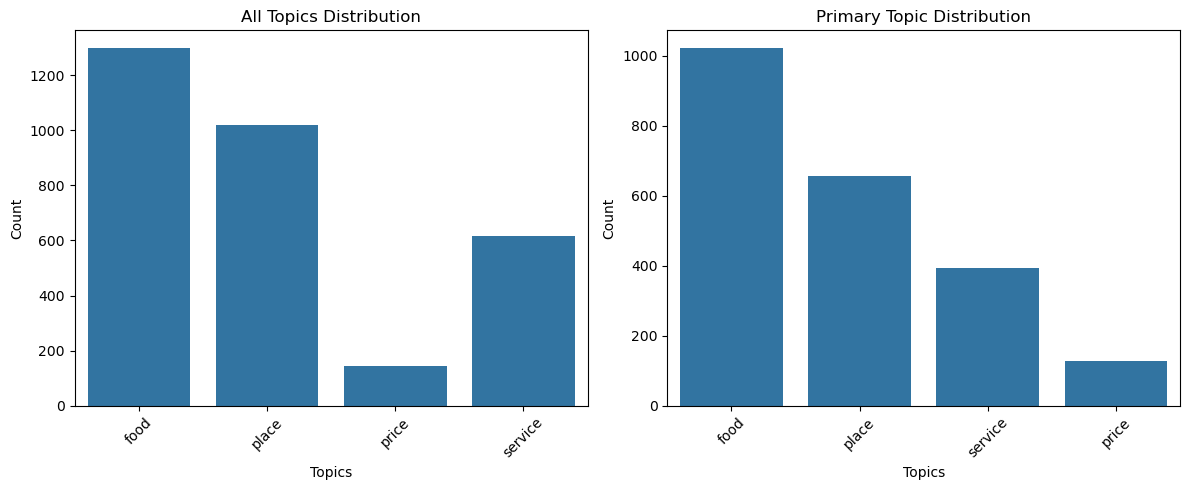


Detailed Results:

Text: To be completely fair, the only redeeming factor was the food, which was above average, but couldn't make up for all the other deficiencies of Teodora.
Primary Topic: food
All Topics: food

Text: The food is uniformly exceptional, with a very capable kitchen which will proudly whip up whatever you feel like eating, whether it's on the menu or not.
Primary Topic: food
All Topics: food, place

Text: Not only was the food outstanding, but the little 'perks' were great.
Primary Topic: food
All Topics: food

Text: It is very overpriced and not very tasty.
Primary Topic: food
All Topics: food

Text: Our agreed favorite is the orrechiete with sausage and chicken (usually the waiters are kind enough to split the dish in half so you get to sample both meats).
Primary Topic: food
All Topics: food, place

Text: The Bagels have an outstanding taste with a terrific texture, both chewy yet not gummy.
Primary Topic: food
All Topics: food

Text: Nevertheless the food itself i

In [15]:
report = analyzer.generate_analysis_report(results_df)
print("\nAnalysis Report:")
print(f"Total texts analyzed: {report['total_texts']}")
print("\nTopic Distribution:")
for topic, count in report['topic_distribution'].items():
    print(f"{topic}: {count}")
print("\nPrimary Topic Distribution:")
for topic, count in report['primary_topic_distribution'].items():
    print(f"{topic}: {count}")

analyzer.plot_topic_distribution(results_df)

print("\nDetailed Results:")
for idx in range(10):
    text = results_df.iloc[idx]['text']
    primary = results_df.iloc[idx]['primary_topic']
    all_topics = results_df.iloc[idx]['main_topics']
    print(f"\nText: {text}")
    print(f"Primary Topic: {primary}")
    print(f"All Topics: {all_topics}")

In [16]:
results_df.to_csv("temporary_result.csv")

# Eksperimen

In [21]:
models = [
    # 'all-MiniLM-L6-v2',
    # 'all-mpnet-base-v2',
    # 'paraphrase-multilingual-MiniLM-L12-v2',
    'all-MiniLM-L12-v2'
]
thresholds = [0.2, 0.3, 0.4]

for model_name in models:
    for threshold in thresholds:
        print(f"Processing model: {model_name}, with threshold: {threshold}")
        analyzer = RestaurantTopicAnalyzer(
            similarity_threshold=threshold,
            device='mps' if torch.backends.mps.is_available() else 'cpu',
            embedding_model=model_name
        )
        
        results_df = analyzer.analyze_dataframe(final_df)
        
        filename = f"results_{model_name}_threshold_{threshold}.csv"
        results_df.to_csv(filename, index=False)
        print(f"Saved results to {filename}")

Processing model: all-MiniLM-L12-v2, with threshold: 0.2
Analyzing texts on mps...


100%|███████████████████████████████████████| 2200/2200 [00:46<00:00, 46.99it/s]


Saved results to results_all-MiniLM-L12-v2_threshold_0.2.csv
Processing model: all-MiniLM-L12-v2, with threshold: 0.3
Analyzing texts on mps...


100%|███████████████████████████████████████| 2200/2200 [00:48<00:00, 45.21it/s]


Saved results to results_all-MiniLM-L12-v2_threshold_0.3.csv
Processing model: all-MiniLM-L12-v2, with threshold: 0.4
Analyzing texts on mps...


100%|███████████████████████████████████████| 2200/2200 [00:46<00:00, 46.96it/s]

Saved results to results_all-MiniLM-L12-v2_threshold_0.4.csv
